In [1]:
datasets = ["authors", "periods", "recipes"]

In [2]:
import random
import os
from shutil import copytree

def split_dataset(path, p=0.6):
    """Split the dataset at given path into learning and testing."""
    random.seed(42)  # for reproducibility

    for dc in next(os.walk(path))[1]:
        documents = next(os.walk("%s/%s" % (path, dc)))[1]
        random.shuffle(documents)
        n = int(len(documents) * p)
        split = [(documents[n:], "training"), (documents[:n], "testing")]

        [
            copytree("%s/%s/%s" % (path, dc, d),
                     "%s-%s/%s/%s" % (path, target, dc, d))
            for documents_set, target in split
            if not os.path.isdir("%s-%s" % (path, dc)) for d in documents_set
        ]

In [3]:
from collections import Counter
import re

def directory_counter(path):
    regex = re.compile(r"\W+")
    counter = Counter()
    for document_path in next(os.walk(path))[2]:
        with open("%s/%s" % (path, document_path), "r") as f:
            counter.update(word for word in re.split(regex, f.read()) if word)
    return counter

In [4]:
def build_keymap(counters):
    keyset = set()
    for counter in counters:
        keyset |= set(counter)
    return {k:i for i, k in enumerate(keyset)}

In [5]:
import numpy as np


def counters_to_nparray(counters, keys):
    zeros = np.zeros((len(counters), len(keys)))
    for j, counter in enumerate(counters):
        for k, v in counter.items():
            if k in keys:
                zeros[j][keys[k]] = v
        zeros[j] /= np.sum(zeros[j])
    return zeros

In [6]:
import json


def build_dataset(dataset):
    counters_classes = {}
    for document_class in next(os.walk("%s-training" % (dataset)))[1]:
        class_path = "%s-training/%s" % (dataset, document_class)
        counters_classes[document_class] = [
            directory_counter("%s/%s" % (class_path, document))
            for document in next(os.walk(class_path))[1]
        ]
    keymap = build_keymap([
        counter for counters in counters_classes.values()
        for counter in counters
    ])
    with open("%s-keymap.json", "w") as f:
        json.dump(keymap, f)
    classes = {}
    for document_class, counters in counters_classes.items():
        classes[document_class] = counters_to_nparray(counters, keymap)
    return classes

In [7]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import cnames

def plot_clusters(clusters, title, labels = None):
    plt.figure(figsize=(10, 10))
    plt.title('%s dataset 2 component PCA' % title.capitalize(), fontsize=20)
    colors = ["black", "blue", "red","brown", "cyan", "gold", "magenta","green", "grey", "indigo"]
    targets = range(clusters.groupby('target').nunique().shape[0])
    if len(targets)>len(colors):
        colors += list(cnames.items())
    if labels is None:
        labels = range(1, len(targets)+1)
    for target, color in zip(targets, colors):
        indicesToKeep = clusters['target'] == target
        if indicesToKeep.any():
            plt.scatter(
                clusters.loc[indicesToKeep, 'a'],
                clusters.loc[indicesToKeep, 'b'],
                alpha=0.8,
                c=color,
                s=20,
                label=labels[target])
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_pca(classes, title):
    data = np.vstack(classes.values())
    labels = np.vstack([
        np.full((len(counters), 1), i)
        for i, counters in enumerate(classes.values())
    ])
    pca = PCA(n_components=2)

    clusters = pd.concat(
        [
            pd.DataFrame(data=pca.fit_transform(data), columns=['a', 'b']),
            pd.DataFrame(labels, columns=("target", ))
        ],
        axis=1)

    plot_clusters(clusters, title, list(classes.keys()))

In [8]:
from sklearn.cluster import KMeans

In [9]:
classes = build_dataset("recipes")

In [10]:
data = classes["recipes"]

In [11]:
from tqdm import tqdm_notebook as tqdm

In [12]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(data)

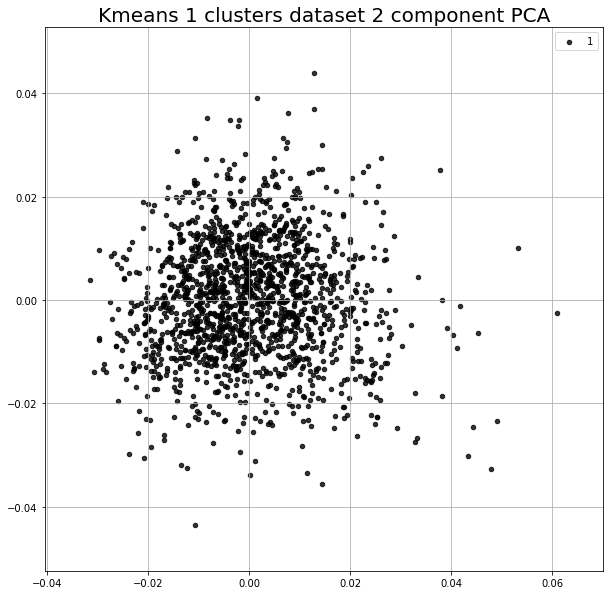

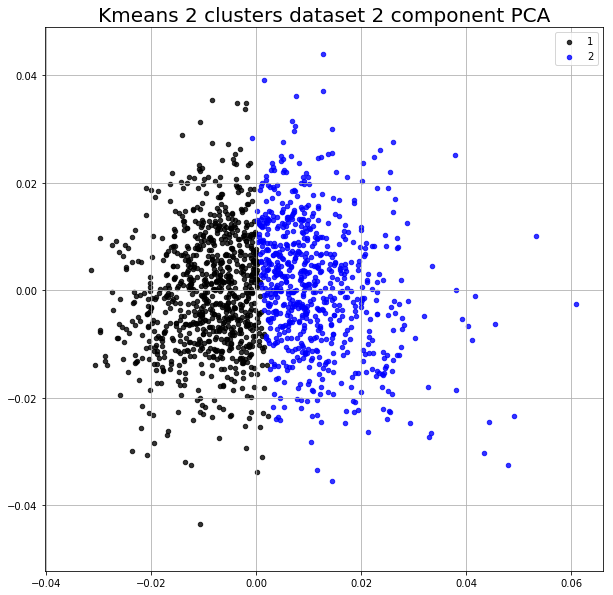

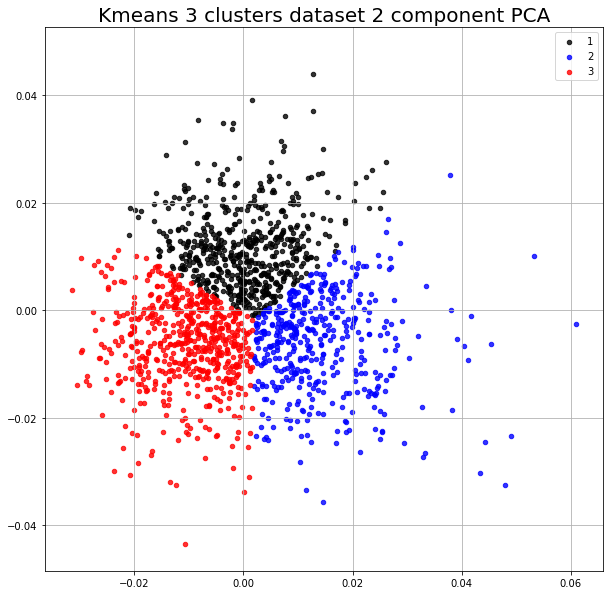

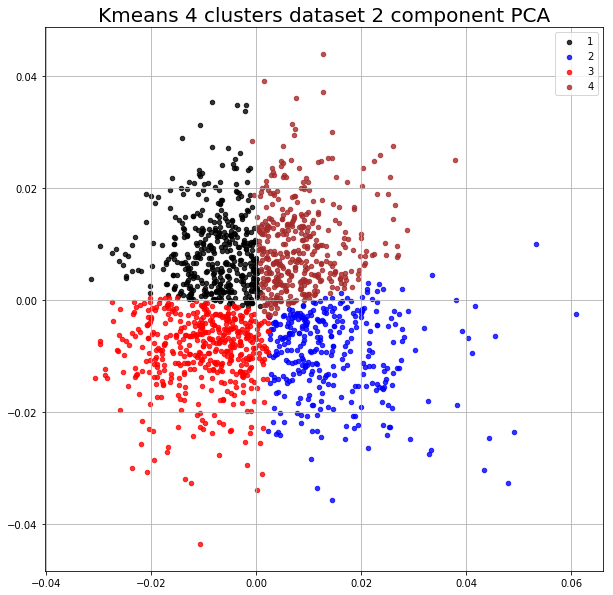

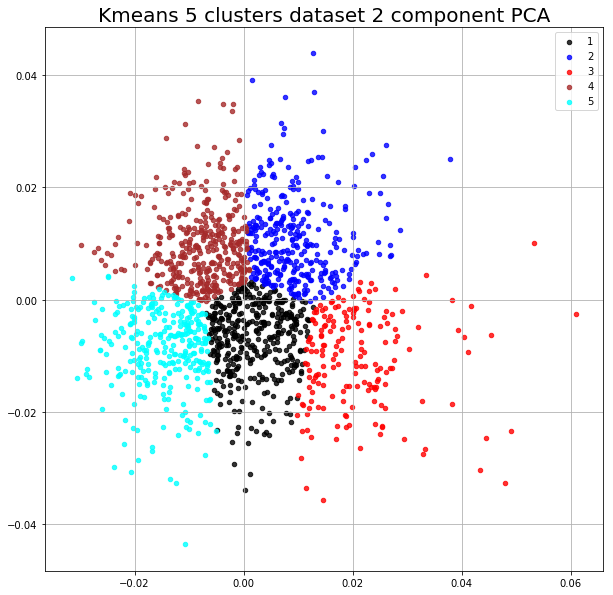

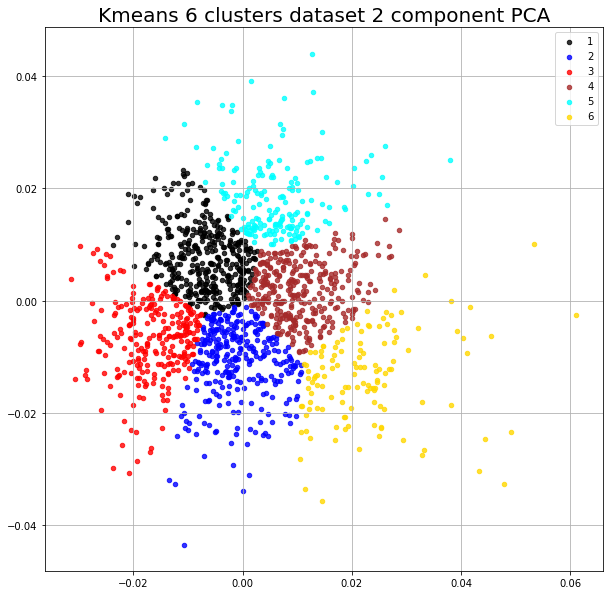

In [15]:
y = []
x = []
for k in tqdm(range(1, 6 + 1)):
    n = 10
    scores = np.empty(shape=(k))
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced)
    centroids = kmeans.cluster_centers_
    predictions = kmeans.predict(reduced)
    distances = np.sum(np.power(reduced - centroids[predictions], 2), axis=1)
    for i in range(k):
        cluster_data = distances[predictions == i]
        m = np.min([n, cluster_data.shape[0]])
        area = np.mean(cluster_data[np.argpartition(cluster_data,
                                                           -m)[-m:]])
        if area == 0:
            area = 1
        density = 1 / area
        scores[i] = (cluster_data.shape[0] / reduced.shape[0])**k* density
    mean_score = np.sum(scores)
    
    clusters = pd.concat(
        [
            pd.DataFrame(data=reduced, columns=['a', 'b']),
            pd.DataFrame(predictions, columns=("target", ))
        ],
        axis=1)
    
    plot_clusters(clusters, "KMeans %s clusters"%k)

    y.append(mean_score)
    x.append(k)

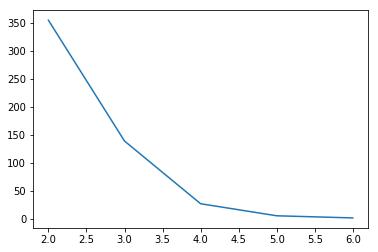

In [14]:
plt.plot(x,y)